<a href="https://colab.research.google.com/github/OsirisEscaL/Parkinson_Project/blob/main/LinearSVC_Parkinson_HeredetaryAtaxias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, SequentialFeatureSelector, SelectFromModel, RFE
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from sklearn.model_selection import GridSearchCV

In [2]:
ds = pd.read_csv('Parkinson_HeredetaryAtaxias.csv') # Cambiar dataset
ds = ds.drop(['Unnamed: 0'], axis=1)
X = ds.iloc[:, 0:-1].values
y = ds.iloc[:, -1].values

rng = np.random.default_rng(seed=42)
random = rng.integers(10000, size=50)

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [3]:
from sklearn.svm import LinearSVC
model = LinearSVC(max_iter=10000, random_state = 42)

In [4]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(scaled_X, y):
        X_train, X_test = scaled_X[train_index], scaled_X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['LinearSVC'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_base = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
LinearSVC,0.662,0.590445,0.76072,0.809708,0.590445,0.729891,0.451,0.044319,0.057042,0.034596,0.03254,0.057042,0.047134,0.099745


Oversampling

In [5]:
methods = [
    ("Random Over Sampler", RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ("SMOTE", SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ("ADASYN", ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)),
    ("BorderlineSMOTE", BorderlineSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, m_neighbors=10)),
    ("SVMSMOTE", SVMSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, m_neighbors=10)),
    ("KMeansSMOTE", KMeansSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=2, cluster_balance_threshold=0.01))
]

In [6]:
results = {}
results_raw = {}

for method_name, method in methods:
    sample_x, sample_y = method.fit_resample(scaled_X, y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for num in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=num)
        for train_index, test_index in stratified_kfold.split(sample_x,sample_y):
            X_train, X_test = sample_x[train_index], sample_x[test_index]
            y_train, y_test = sample_y[train_index], sample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[method_name] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[method_name] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_over_ds = pd.DataFrame(results_raw)
results_raw_over_ds.to_csv('Results_Raw_Oversampling_LinearSVC.csv')

results_over_ds = pd.DataFrame(results).T
results_over_ds.to_csv('Results_Oversampling_LinearSVC.csv')
results_over_ds

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
Random Over Sampler,0.835073,0.029097,0.835359,0.028938,0.959134,0.044976,0.706436,0.039622,0.963709,0.042390,0.805842,0.033474,0.835073,0.029097
SMOTE,0.824782,0.020732,0.824935,0.020149,0.932209,0.030060,0.707127,0.039501,0.942436,0.028507,0.796541,0.027469,0.824782,0.020732
ADASYN,0.840597,0.024803,0.845818,0.024458,0.973954,0.030292,0.702073,0.039553,0.979121,0.025150,0.808964,0.031780,0.840597,0.024803
BorderlineSMOTE,0.834945,0.022373,0.835074,0.022202,0.963561,0.031066,0.700836,0.036959,0.969055,0.027390,0.803814,0.028758,0.834945,0.022373
SVMSMOTE,0.813624,0.027826,0.793778,0.028645,0.938848,0.027390,0.701891,0.041851,0.925357,0.037138,0.794988,0.031931,0.813624,0.027826
KMeansSMOTE,0.822109,0.019584,0.822952,0.019357,0.907280,0.017722,0.722218,0.039106,0.922000,0.015814,0.796236,0.026227,0.822109,0.019584


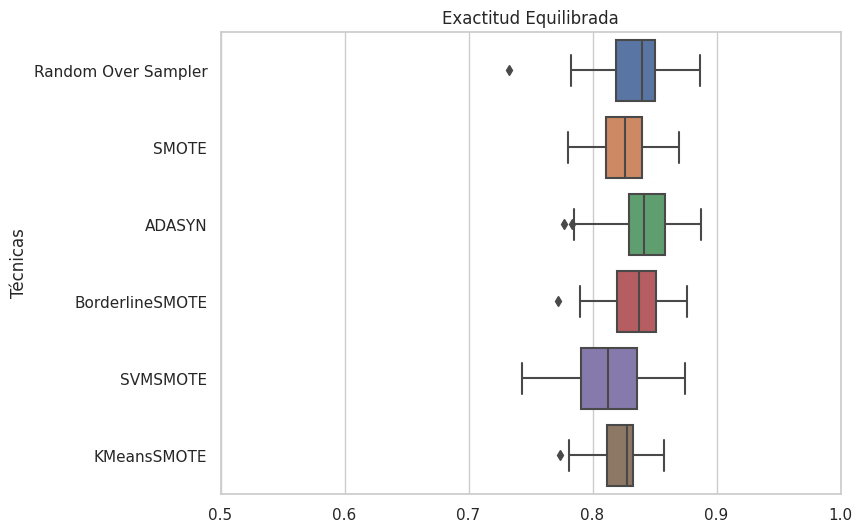

In [7]:
balanced_accuracy = pd.DataFrame(results_raw_over_ds.loc['Balanced_Accuracy'])
modelos = balanced_accuracy.index

plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.boxplot(data=balanced_accuracy['Balanced_Accuracy'], orient='h')
plt.title('Exactitud Equilibrada')
plt.xlim(0.5, 1)
plt.ylabel('Técnicas')
plt.gca().set_yticklabels(modelos)
plt.savefig('Boxplot_Oversampling_LinearSVC.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
samplers = ['Random Over Sampler', 'SMOTE', 'ADASYN', 'BorderlineSMOTE',
            'SVMSMOTE', 'KMeansSMOTE']

comparison = {}
alpha = 0.05
for sample1 in samplers:
  val1 = results_raw_over_ds.loc['Balanced_Accuracy', sample1]
  for sample2 in samplers:
    val2 = results_raw_over_ds.loc['Balanced_Accuracy', sample2]
    statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='two-sided')
    if p_value < alpha:
      statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='greater')
      if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
      else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
    else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
      comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}

comparison = pd.DataFrame(comparison).T
comparison.to_csv('MannWhitneyU_Oversampling_LinearSVC.csv')
comparison

statistic   p_value  \
Random Over Sampler Random Over Sampler    1250.0       1.0   
                    SMOTE                  1578.5  0.011852   
                    ADASYN                 1082.0  0.248082   
                    BorderlineSMOTE        1277.0  0.855007   
                    SVMSMOTE               1779.5  0.000133   
                    KMeansSMOTE            1622.5  0.005153   
SMOTE               Random Over Sampler     921.5  0.988359   
                    SMOTE                  1250.0       1.0   
                    ADASYN                  734.5  0.999813   
                    BorderlineSMOTE         910.5  0.990474   
                    SVMSMOTE               1555.0  0.017895   
                    KMeansSMOTE            1295.5  0.756285   
ADASYN              Random Over Sampler    1418.0  0.248082   
                    SMOTE                  1765.5  0.000192   
                    ADASYN                 1250.0       1.0   
                    BorderlineSMOTE        1456.5  0.155478   
                    SVMSMOTE               1922.5  0.000002   
                    KMeansSMOTE            1845.5   0.00002   
BorderlineSMOTE     Random Over Sampler    1223.0  0.855007   
                    SMOTE                  1589.5  0.009703   
                    ADASYN                 1043.5  0.155478   
                    BorderlineSMOTE        1250.0       1.0   
                    SVMSMOTE               1798.5  0.000079   
                    KMeansSMOTE            1649.5  0.002967   
SVMSMOTE            Random Over Sampler     720.5  0.999871   
                    SMOTE                   945.0  0.982407   
                    ADASYN                  577.5  0.999998   
                    BorderlineSMOTE         701.5  0.999923   
                    SVMSMOTE               1250.0       1.0   
                    KMeansSMOTE            1026.0  0.123326   
KMeansSMOTE         Random Over Sampler     877.5  0.994949   
                    SMOTE                  1204.5  0.756285   
                    ADASYN                  654.5   0.99998   
                    BorderlineSMOTE         850.5  0.997095   
                    SVMSMOTE               1474.0  0.123326   
                    KMeansSMOTE            1250.0       1.0   

                                                                                   greater  
Random Over Sampler Random Over Sampler  No hay evidencia suficiente para afirmar que l...  
                    SMOTE                La primera muestra es significativamente mayor...  
                    ADASYN               No hay evidencia suficiente para afirmar que l...  
                    BorderlineSMOTE      No hay evidencia suficiente para afirmar que l...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE          La primera muestra es significativamente mayor...  
SMOTE               Random Over Sampler  La primera muestra no es significativamente ma...  
                    SMOTE                No hay evidencia suficiente para afirmar que l...  
                    ADASYN               La primera muestra no es significativamente ma...  
                    BorderlineSMOTE      La primera muestra no es significativamente ma...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE          No hay evidencia suficiente para afirmar que l...  
ADASYN              Random Over Sampler  No hay evidencia suficiente para afirmar que l...  
                    SMOTE                La primera muestra es significativamente mayor...  
                    ADASYN               No hay evidencia suficiente para afirmar que l...  
                    BorderlineSMOTE      No hay evidencia suficiente para afirmar que l...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE   

In [9]:
oversampler = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5) # Cambiar dependiendo cual fue mejor
oversample_X, oversample_y = oversampler.fit_resample(scaled_X, y)

In [10]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(oversample_X,oversample_y):
        X_train, X_test = oversample_X[train_index], oversample_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['LinearSVC'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_over = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
LinearSVC,0.845818,0.840597,0.808964,0.973954,0.840597,0.702073,0.979121,0.024458,0.024803,0.03178,0.030292,0.024803,0.039553,0.02515


In [11]:
statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_over, modelbalanced_accuracy_base, alternative='two-sided')
if p_value < alpha:
    statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_over, modelbalanced_accuracy_base, alternative='greater')
    if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
    else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
print('statistic:',statistic,'p_value', p_value, greater)

statistic: 2500.0 p_value 3.5242809763618545e-18 La primera muestra es significativamente mayor que la segunda.


Feature Selection

In [12]:
ds_X = ds.iloc[:, 0:-1]
features = ds_X.shape[1]

In [13]:
# SelectKBest
results = {}
results_raw = {}

for num in range(1, features):
    selector = SelectKBest(score_func=f_classif, k=num)
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_selectK_ds = pd.DataFrame(results_raw)
results_raw_selectK_ds.to_csv('Results_Raw_SelectKBest_LinearSVC.csv')

results_selectK_ds = pd.DataFrame(results).T
number_of_features = results_selectK_ds.index + 1
results_selectK_ds.insert(0, 'Number_Features', number_of_features)
results_selectK_ds = results_selectK_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_selectK_ds.to_csv('Results_SelectKBest_LinearSVC.csv')
results_selectK_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
31,32,0.879391,0.021955,0.883273,0.021387,0.984375,0.025467,0.772509,0.033985,0.986273,0.022398,0.857133,0.028335,0.879391,0.021955
41,42,0.866609,0.023565,0.871091,0.022976,0.983993,0.025971,0.746582,0.041668,0.986636,0.020311,0.842338,0.030343,0.866609,0.023565
32,33,0.865721,0.027466,0.869636,0.026698,0.977746,0.028461,0.751382,0.043914,0.980061,0.024805,0.840120,0.033663,0.865721,0.027466
37,38,0.863324,0.028780,0.867455,0.028055,0.978161,0.027585,0.744800,0.047148,0.981848,0.021981,0.837974,0.036627,0.863324,0.028780
42,43,0.862797,0.022981,0.867455,0.022275,0.983927,0.026311,0.739018,0.040676,0.986576,0.021683,0.837087,0.029607,0.862797,0.022981


In [14]:
best_number_K = 32 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_K = SelectKBest(score_func=f_classif, k=best_number_K)
new_X_K = selector_K.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_K.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SelectKBest:")
print(selected_feature_names)

Características seleccionadas usando SelectKBest:
Index(['Mean_step_lenght_Der', 'Velocity_Der', 'RMS_AP_Der', 'Freq_50_VER_Der',
       'Freq_90_ML_Der', 'Freq_100_ML_Der', 'IPSD_AP_Der', 'Freq_75_AP_Der',
       'Freq_90_AP_Der', 'Freq_100_AP_Der', 'Sym_AP_Der', 'Stride_Reg_ML_Der',
       'Cadence_Izq', 'Mean_step_lenght_Izq', 'Velocity_Izq', 'RMS_ML_Izq',
       'RMS_AP_Izq', 'Freq_50_VER_Izq', 'Freq_75_VER_Izq', 'Freq_90_VER_Izq',
       'Freq_100_VER_Izq', 'IPSD_ML_Izq', 'Freq_75_ML_Izq', 'Freq_90_ML_Izq',
       'IPSD_AP_Izq', 'Freq_75_AP_Izq', 'Freq_90_AP_Izq', 'Freq_100_AP_Izq',
       'Sym_AP_Izq', 'Stride_Reg_AP_Izq', 'Step_Reg_VER_Izq',
       'Step_Reg_AP_Izq'],
      dtype='object')


In [15]:
# SelectFromModel
results = {}
results_raw = {}

for num in range(1, features):
    selector = SelectFromModel(model, max_features=num)
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_select_ds = pd.DataFrame(results_raw)
results_raw_select_ds.to_csv('Results_Raw_SelectM_LinearSVC_.csv')

results_select_ds = pd.DataFrame(results).T
number_of_features = results_select_ds.index + 1
results_select_ds.insert(0, 'Number_Features', number_of_features)
results_select_ds = results_select_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_select_ds.to_csv('Results_SelectM_LinearSVC_.csv')
results_select_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
13,14,0.961215,0.014564,0.962545,0.014158,0.992473,0.015766,0.929855,0.025964,0.992576,0.015417,0.957827,0.016368,0.961215,0.014564
14,15,0.957124,0.014301,0.958545,0.013866,0.992194,0.015952,0.922036,0.024536,0.992212,0.015874,0.953401,0.015845,0.957124,0.014301
42,43,0.951158,0.015680,0.952727,0.015103,0.991758,0.016113,0.910436,0.027874,0.991879,0.015882,0.946533,0.017677,0.951158,0.015680
31,32,0.951158,0.015680,0.952727,0.015103,0.991758,0.016113,0.910436,0.027874,0.991879,0.015882,0.946533,0.017677,0.951158,0.015680
32,33,0.951158,0.015680,0.952727,0.015103,0.991758,0.016113,0.910436,0.027874,0.991879,0.015882,0.946533,0.017677,0.951158,0.015680


In [16]:
best_number_M = 14 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_M = SelectFromModel(model, max_features=best_number_M)
new_X_M = selector_M.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_M.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SelectFromModel:")
print(selected_feature_names)

Características seleccionadas usando SelectFromModel:
Index(['RMS_AP_Der', 'IPSD_VER_Der', 'Freq_75_ML_Der', 'Freq_100_ML_Der',
       'Freq_75_AP_Der', 'Freq_100_AP_Der', 'Sym_AP_Der', 'Stride_Reg_ML_Der',
       'Stride_Reg_AP_Der', 'Freq_75_VER_Izq', 'Freq_90_VER_Izq',
       'Freq_50_AP_Izq', 'Freq_100_AP_Izq', 'Step_Reg_AP_Izq'],
      dtype='object')


In [17]:
# RFE
results = {}
results_raw = {}

for num in range(1, features):
    selector = RFE(model, n_features_to_select=num)
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_recursive_ds = pd.DataFrame(results_raw)
results_raw_recursive_ds.to_csv('Results_Raw_RFE_LinearSVC.csv')

results_recursive_ds = pd.DataFrame(results).T
number_of_features = results_recursive_ds.index + 1
results_recursive_ds.insert(0, 'Number_Features', number_of_features)
results_recursive_ds = results_recursive_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_recursive_ds.to_csv('Results_RFE_LinearSVC.csv')
results_recursive_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
21,22,0.980058,0.016127,0.980545,0.015852,0.994943,0.014136,0.965055,0.027096,0.995061,0.013663,0.978007,0.018251,0.980058,0.016127
22,23,0.975494,0.017552,0.976182,0.017045,0.995661,0.013456,0.955200,0.031274,0.995788,0.012918,0.973142,0.019655,0.975494,0.017552
24,25,0.972697,0.016061,0.973455,0.015834,0.995657,0.013286,0.949273,0.027868,0.996121,0.011908,0.970169,0.018279,0.972697,0.016061
26,27,0.971479,0.013360,0.972364,0.012979,0.997081,0.010479,0.945382,0.024298,0.997576,0.008463,0.968564,0.015754,0.971479,0.013360
23,24,0.971403,0.015212,0.972182,0.015038,0.995534,0.013786,0.947018,0.025979,0.995788,0.012918,0.968890,0.017071,0.971403,0.015212


In [18]:
best_number_R = 22 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_R = RFE(model, n_features_to_select=best_number_R)
new_X_R = selector_R.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_R.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando RFE:")
print(selected_feature_names)

Características seleccionadas usando RFE:
Index(['Cadence_Der', 'Velocity_Der', 'RMS_AP_Der', 'IPSD_VER_Der',
       'Freq_75_ML_Der', 'Freq_90_ML_Der', 'Freq_75_AP_Der', 'Freq_100_AP_Der',
       'Sym_AP_Der', 'Stride_Reg_ML_Der', 'Step_Reg_AP_Der', 'Cadence_Izq',
       'RMS_ML_Izq', 'IPSD_VER_Izq', 'Freq_75_VER_Izq', 'Freq_90_VER_Izq',
       'Freq_50_ML_Izq', 'Freq_100_ML_Izq', 'Freq_50_AP_Izq', 'Freq_90_AP_Izq',
       'Freq_100_AP_Izq', 'Step_Reg_AP_Izq'],
      dtype='object')


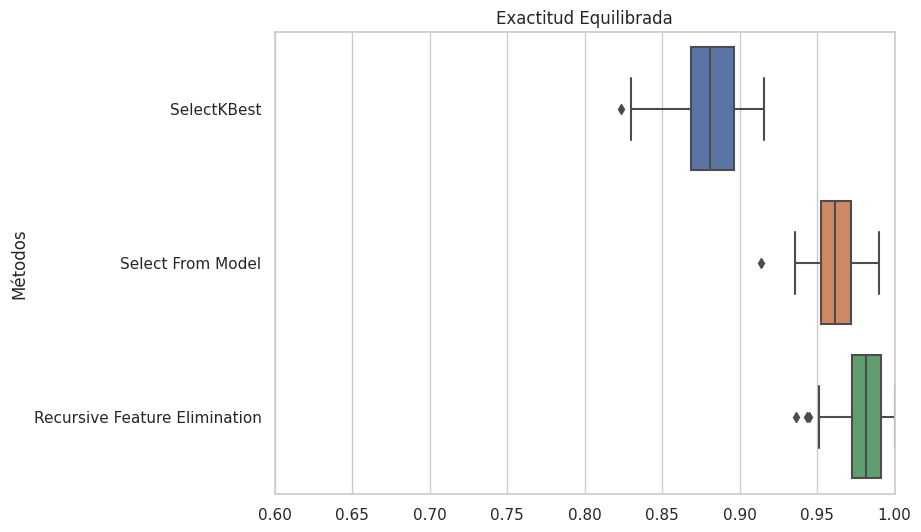

In [19]:
raw_SelectKBest = results_raw_selectK_ds.iloc[0, best_number_K-1]
raw_SelectM = results_raw_select_ds.iloc[0, best_number_M-1]
raw_RFE = results_raw_recursive_ds.iloc[0, best_number_R-1]

raw_SelectKBest = pd.Series(raw_SelectKBest, name='SelectKBest')
raw_SelectM = pd.Series(raw_SelectM, name='Select From Model')
raw_RFE = pd.Series(raw_RFE, name='Recursive Feature Elimination')

FeaturesSelectors = pd.concat([raw_SelectKBest, raw_SelectM, raw_RFE], axis=1)

plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.boxplot(data=FeaturesSelectors, orient='h')
plt.title('Exactitud Equilibrada')
plt.xlim(0.6, 1)
plt.ylabel('Métodos')
plt.savefig('Boxplot_FeatureSelection_LinearSVC.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
samplers = ['SelectKBest', 'Select From Model',
            'Recursive Feature Elimination']

comparison = {}
alpha = 0.05
for sample1 in samplers:
  val1 = FeaturesSelectors.loc[:, sample1]
  for sample2 in samplers:
    val2 = FeaturesSelectors.loc[:, sample2]
    statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='two-sided')
    if p_value < alpha:
      statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='greater')
      if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
      else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
    else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
      comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}

comparison = pd.DataFrame(comparison).T
comparison.to_csv('MannWhitneyU_FeaturesSelection_LinearSVC.csv')
comparison

statistic p_value  \
SelectKBest                   SelectKBest                      1250.0     1.0   
                              Select From Model                   1.0     1.0   
                              Recursive Feature Elimination       0.0     1.0   
Select From Model             SelectKBest                      2499.0     0.0   
                              Select From Model                1250.0     1.0   
                              Recursive Feature Elimination     436.0     1.0   
Recursive Feature Elimination SelectKBest                      2500.0     0.0   
                              Select From Model                2064.0     0.0   
                              Recursive Feature Elimination    1250.0     1.0   

                                                                                                       greater  
SelectKBest                   SelectKBest                    No hay evidencia suficiente para afirmar que l...  
                              Select From Model              La primera muestra no es significativamente ma...  
                              Recursive Feature Elimination  La primera muestra no es significativamente ma...  
Select From Model             SelectKBest                    La primera muestra es significativamente mayor...  
                              Select From Model              No hay evidencia suficiente para afirmar que l...  
                              Recursive Feature Elimination  La primera muestra no es significativamente ma...  
Recursive Feature Elimination SelectKBest                    La primera muestra es significativamente mayor...  
                              Select From Model              La primera muestra es significativamente mayor...  
                              Recursive Feature Elimination  No hay evidencia suficiente para afirmar que l...

In [21]:
best_number = 22 # Cambiar dependiendo cual fue mejor
selector = RFE(model, n_features_to_select=best_number) # Cambiar dependiendo cual fue mejor
new_X = selector.fit_transform(oversample_X, oversample_y)

In [22]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
        X_train, X_test = new_X[train_index], new_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['LinearSVC'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_select = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
LinearSVC,0.980545,0.980058,0.978007,0.994943,0.980058,0.965055,0.995061,0.015852,0.016127,0.018251,0.014136,0.016127,0.027096,0.013663


In [23]:
statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_select, modelbalanced_accuracy_over, alternative='two-sided')
if p_value < alpha:
    statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_over, modelbalanced_accuracy_base, alternative='greater')
    if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
    else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
print('statistic:',statistic,'p_value', p_value, greater)

statistic: 2500.0 p_value 3.5242809763618545e-18 La primera muestra es significativamente mayor que la segunda.


Hyperparameter Tunning

In [24]:
parameters = {
    'C': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=50,  scoring='balanced_accuracy')
grid_search.fit(new_X, oversample_y)

print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'C': 1}


In [25]:
model_hyper = LinearSVC(C=1, max_iter=10000, random_state = 42)

In [26]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
        X_train, X_test = new_X[train_index], new_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model_hyper.fit(X_train, y_train)
        y_pred = model_hyper.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['LinearSVC'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_hyper = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
LinearSVC,0.980545,0.980058,0.978007,0.994943,0.980058,0.965055,0.995061,0.015852,0.016127,0.018251,0.014136,0.016127,0.027096,0.013663


In [27]:
statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_hyper, modelbalanced_accuracy_select, alternative='two-sided')
if p_value < alpha:
    statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_over, modelbalanced_accuracy_base, alternative='greater')
    if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
    else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
print('statistic:',statistic,'p_value', p_value, greater)

statistic: 1250.0 p_value 1.0 No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.


Resultados y Curva ROC

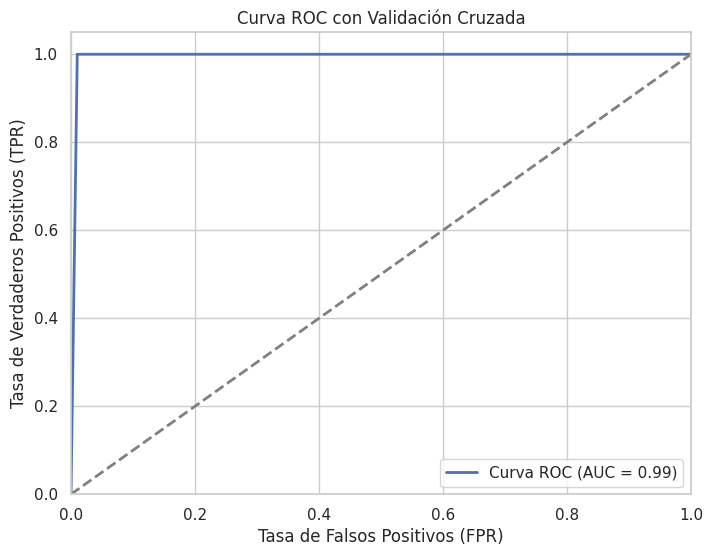

In [28]:
model_best = model #Cambie para colocar el parametro probability
cv = StratifiedKFold(n_splits=50, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for train_index, test_index in cv.split(new_X, oversample_y):
    X_train, X_test = new_X[train_index], new_X[test_index]
    y_train, y_test = oversample_y[train_index], oversample_y[test_index]
    model_best.fit(X_train, y_train)
    decision_scores = model_best.decision_function(X_test)
    prob_pos = 1 / (1 + np.exp(-decision_scores))

    fpr, tpr, _ = roc_curve(y_test, prob_pos)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

mean_tpr = np.mean(tprs, axis=0)
roc_auc = auc(mean_fpr, mean_tpr)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC con Validación Cruzada')
plt.legend(loc='lower right')
plt.savefig('ROCCurve_LinearSVC.png', dpi=300, bbox_inches='tight')
plt.show()